#=====================================================================================================================================================


In [ ]:
# So I grouped the variables according to the theme.
# I ran logistic regrassion, SVM, and Decision tree for each theme and confusion matrix for each
# I then picked the best model for each theme and combined them into a stacked model. The stacked model is the last cell.



In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create Dataframe for original
url = 'https://raw.githubusercontent.com/shantanu1109/IBM-HR-Analytics-Employee-Attrition-and-Performance-Prediction/main/DATASET/IBM-HR-Analytics-Employee-Attrition-and-Performance-Revised.csv'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   object
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   object
 12  JobLevel                  1470 non-null   object
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [ ]:
df['Attrition'].value_counts()

,count
Attrition,
No,1233
Yes,237


In [ ]:
# ======================================
# These are the vaiables for each theme
# ======================================

# 1. Engagement and Culture         | 2. Wellbeing & Work-Life Balance      | 3. Pay and Benefits
# -----------------------------------------------------------------------------------------------
# Attrition                       | Age                                   | DailyRate
# BusinessTravel                  | DistanceFromHome                      | HourlyRate
# Department                      | Gender                                | MonthlyIncome
# EducationField                  | MaritalStatus                         | MonthlyRate
# EnvironmentSatisfaction         | OverTime                              | PercentSalaryHike
# JobInvolvement                  | TotalWorkingYears                     | StockOptionLevel
# JobRole                         | TrainingTimesLastYear                 | Education
# JobSatisfaction                 | WorkLifeBalance                       | JobLevel
# PerformanceRating               | YearsAtCompany                        |
# RelationshipSatisfaction        | YearsSinceLastPromotion               |
# YearsInCurrentRole              | NumCompaniesWorked                    |
# YearsWithCurrManager            |                                       |


In [ ]:
# Creating data frames for each theme
engagement_culture_cols = [
    'Attrition', 'BusinessTravel', 'Department', 'EducationField',
    'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction',
    'PerformanceRating', 'RelationshipSatisfaction',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]

wellbeing_cols = [
    'Attrition','Age', 'DistanceFromHome', 'Gender', 'MaritalStatus', 'OverTime',
    'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
    'YearsAtCompany', 'YearsSinceLastPromotion', 'NumCompaniesWorked'
]

pay_benefits_cols = [
    'Attrition','DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
    'PercentSalaryHike', 'StockOptionLevel', 'Education', 'JobLevel'
]

# Create new DataFrames for each theme
df_engagement = df[engagement_culture_cols].copy()
df_wellbeing = df[wellbeing_cols].copy()
df_pay = df[pay_benefits_cols].copy()

In [ ]:
df_engagement.head()

,Attrition,BusinessTravel,Department,EducationField,EnvironmentSatisfaction,JobInvolvement,JobRole,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,YearsInCurrentRole,YearsWithCurrManager
0,Yes,Travel_Rarely,Sales,Life Sciences,Medium,High,Sales Executive,Very High,Excellent,Low,4,5
1,No,Travel_Frequently,Research & Development,Life Sciences,High,Medium,Research Scientist,Medium,Outstanding,Very High,7,7
2,Yes,Travel_Rarely,Research & Development,Other,Very High,Medium,Laboratory Technician,High,Excellent,Medium,0,0
3,No,Travel_Frequently,Research & Development,Life Sciences,Very High,High,Research Scientist,High,Excellent,High,7,0
4,No,Travel_Rarely,Research & Development,Medical,Low,High,Laboratory Technician,Medium,Excellent,Very High,2,2


In [ ]:
df_wellbeing.head()


,Attrition,Age,DistanceFromHome,Gender,MaritalStatus,OverTime,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,NumCompaniesWorked
0,Yes,41,1,Female,Single,Yes,8,0,Bad,6,0,8
1,No,49,8,Male,Married,No,10,3,Better,10,1,1
2,Yes,37,2,Male,Single,Yes,7,3,Better,0,0,6
3,No,33,3,Female,Married,Yes,8,3,Better,8,3,1
4,No,27,2,Male,Married,No,6,3,Better,2,2,9


In [ ]:
# ===========================
# Training Smaller Models
# ===========================
#
# 1. Preprocessed the data by:
#    - Encoding categorical features and scaling numerical ones.
#    - Applied SMOTE to handle class imbalance in the training data.
#
# 2. Trained three machine learning models (Logistic Regression, SVM, Decision Tree)
#    on each of the three DataFrames: `df_engagement`, `df_wellbeing`, and `df_pay`.
#
# 3. Evaluated the models' performance by printing out the accuracy and classification report
#    (precision, recall, and F1-score) for each model on the test data.
#
# The process was repeated for each theme (Engagement, Wellbeing, and Pay).

In [ ]:
# Preprocessing function with Dummy Variables and SMOTE
def preprocess_with_smote(df, target='Attrition'):
    X = df.drop(columns=[target])
    y = df[target]

    # Use one-hot encoding (dummy variables) for categorical features
    X = pd.get_dummies(X, drop_first=True)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Apply SMOTE only on training data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    return X_train_res, X_test, y_train_res, y_test


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
# Model functions with SMOTE, saving models to variables
def run_logistic_regression(df, theme_name):
    X_train, X_test, y_train, y_test = preprocess_with_smote(df)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save model to a variable
    globals()[f"logistic_regression_{theme_name}"] = model  # Save to a global variable

    print(f"\n[{theme_name}] Logistic Regression")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, "Logistic Regression")

def run_svm(df, theme_name):
    X_train, X_test, y_train, y_test = preprocess_with_smote(df)
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save model to a variable
    globals()[f"svm_{theme_name}"] = model  # Save to a global variable

    print(f"\n[{theme_name}] SVM")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, "SVM")

def run_decision_tree(df, theme_name):
    X_train, X_test, y_train, y_test = preprocess_with_smote(df)
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save model to a variable
    globals()[f"decision_tree_{theme_name}"] = model  # Save to a global variable

    print(f"\n[{theme_name}] Decision Tree")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, "Decision Tree")


In [ ]:
# After running models, the trained models are saved to variables, e.g., logistic_regression_Engagement, svm_Engagement, decision_tree_Engagement

# Below is a list of the model variables that are created during the execution:

# 1. Logistic Regression Models:
#   - logistic_regression_Engagement
#   - logistic_regression_Wellbeing
#   - logistic_regression_Pay

# 2. SVM Models:
#   - svm_Engagement
#   - svm_Wellbeing
#   - svm_Pay

# 3. Decision Tree Models:
#   - decision_tree_Engagement
#   - decision_tree_Wellbeing
#   - decision_tree_Pay

# These models are saved as global variables. You can access them after training to:
# - Make predictions
# - Evaluate the models further

# Example: If you want to use the logistic regression model for the Engagement theme:
# logistic_regression_Engagement.predict(X_test)






=== Engagement Theme ===

[Engagement] Logistic Regression
Accuracy: 0.6769
              precision    recall  f1-score   support

          No       0.90      0.69      0.78       247
         Yes       0.27      0.60      0.37        47

    accuracy                           0.68       294
   macro avg       0.58      0.64      0.58       294
weighted avg       0.80      0.68      0.72       294



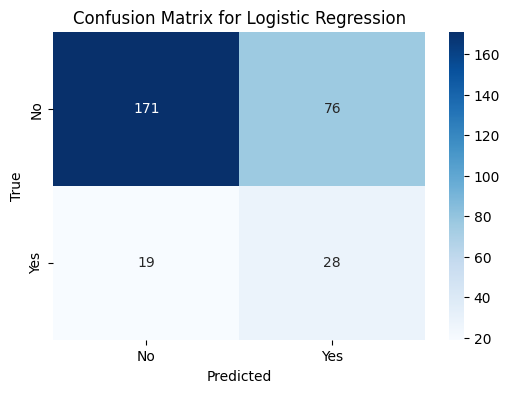


[Engagement] SVM
Accuracy: 0.7551
              precision    recall  f1-score   support

          No       0.86      0.84      0.85       247
         Yes       0.26      0.30      0.28        47

    accuracy                           0.76       294
   macro avg       0.56      0.57      0.57       294
weighted avg       0.77      0.76      0.76       294



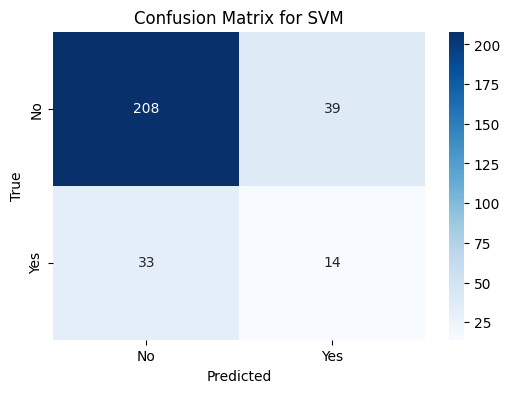


[Engagement] Decision Tree
Accuracy: 0.7891
              precision    recall  f1-score   support

          No       0.89      0.85      0.87       247
         Yes       0.37      0.47      0.42        47

    accuracy                           0.79       294
   macro avg       0.63      0.66      0.64       294
weighted avg       0.81      0.79      0.80       294



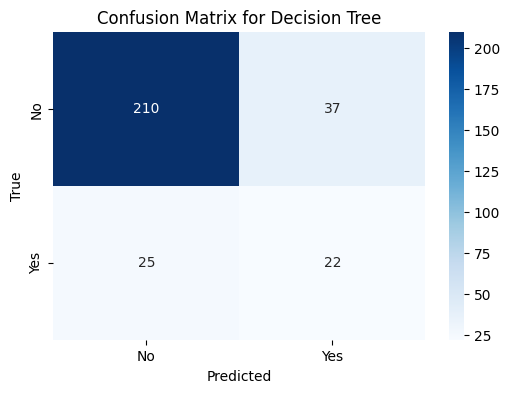

In [ ]:
# Run models for Engagement Theme
def run_models_for_engagement(df_engagement):
    print("\n=== Engagement Theme ===")
    run_logistic_regression(df_engagement, "Engagement")
    run_svm(df_engagement, "Engagement")
    run_decision_tree(df_engagement, "Engagement")


run_models_for_engagement(df_engagement)



=== Wellbeing Theme ===

[Wellbeing] Logistic Regression
Accuracy: 0.7347
              precision    recall  f1-score   support

          No       0.94      0.73      0.82       247
         Yes       0.35      0.77      0.48        47

    accuracy                           0.73       294
   macro avg       0.65      0.75      0.65       294
weighted avg       0.85      0.73      0.77       294



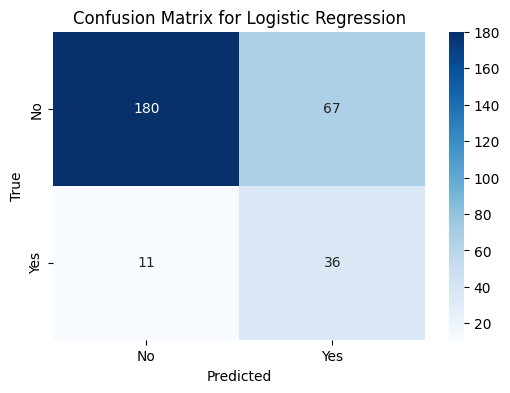


[Wellbeing] SVM
Accuracy: 0.7483
              precision    recall  f1-score   support

          No       0.90      0.79      0.84       247
         Yes       0.33      0.55      0.41        47

    accuracy                           0.75       294
   macro avg       0.62      0.67      0.63       294
weighted avg       0.81      0.75      0.77       294



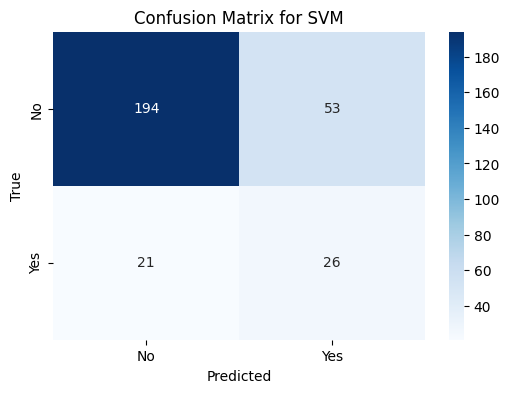


[Wellbeing] Decision Tree
Accuracy: 0.7585
              precision    recall  f1-score   support

          No       0.88      0.83      0.85       247
         Yes       0.30      0.38      0.34        47

    accuracy                           0.76       294
   macro avg       0.59      0.61      0.59       294
weighted avg       0.78      0.76      0.77       294



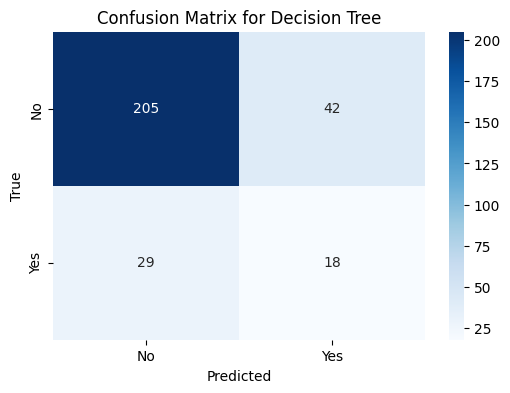

In [ ]:
# Run models for Wellbeing Theme
def run_models_for_wellbeing(df_wellbeing):
    print("\n=== Wellbeing Theme ===")
    run_logistic_regression(df_wellbeing, "Wellbeing")
    run_svm(df_wellbeing, "Wellbeing")
    run_decision_tree(df_wellbeing, "Wellbeing")


run_models_for_wellbeing(df_wellbeing)



=== Pay Theme ===

[Pay] Logistic Regression
Accuracy: 0.6122
              precision    recall  f1-score   support

          No       0.90      0.61      0.72       247
         Yes       0.24      0.64      0.34        47

    accuracy                           0.61       294
   macro avg       0.57      0.62      0.53       294
weighted avg       0.79      0.61      0.66       294



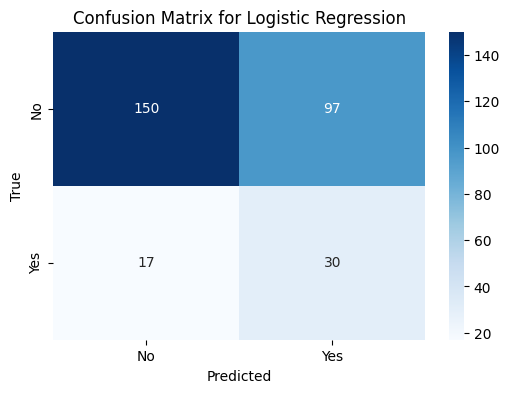


[Pay] SVM
Accuracy: 0.6633
              precision    recall  f1-score   support

          No       0.92      0.66      0.77       247
         Yes       0.28      0.68      0.39        47

    accuracy                           0.66       294
   macro avg       0.60      0.67      0.58       294
weighted avg       0.81      0.66      0.71       294



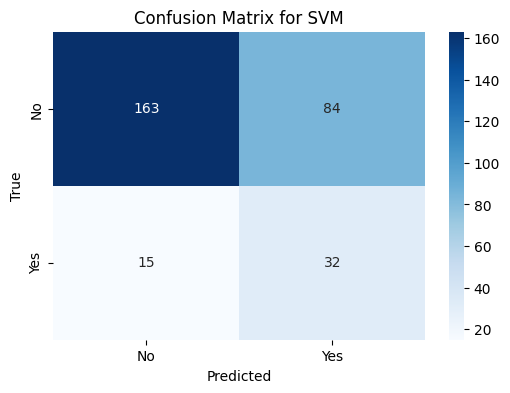


[Pay] Decision Tree
Accuracy: 0.6599
              precision    recall  f1-score   support

          No       0.86      0.72      0.78       247
         Yes       0.20      0.36      0.25        47

    accuracy                           0.66       294
   macro avg       0.53      0.54      0.52       294
weighted avg       0.75      0.66      0.70       294



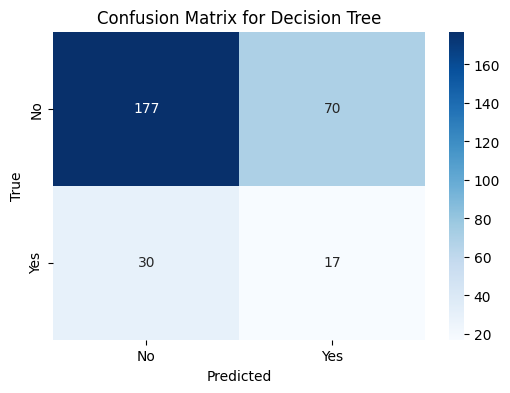

In [ ]:
# Run models for Pay Theme
def run_models_for_pay(df_pay):
    print("\n=== Pay Theme ===")
    run_logistic_regression(df_pay, "Pay")
    run_svm(df_pay, "Pay")
    run_decision_tree(df_pay, "Pay")


run_models_for_pay(df_pay)


In [ ]:
# --- Sub-models used in the Stacking Model ---
# 1. **Engagement-related model**: Decision Tree Classifier (`clf_eng`)
# 2. **Wellbeing-related model**: Support Vector Machine (SVM) (`clf_well`)
# 3. **Pay-related model**: Decision Tree Classifier (`clf_pay`)
#
# These three base models are combined using a **StackingClassifier**, which uses their predictions as input features
# for a **Logistic Regression** model (final estimator) to make the final prediction.

# --- Final Model Saved ---
# The final stacked model is stored in the `trained_stacked_model` variable.
# You can also save it to a file using `joblib.dump(trained_stacked_model, 'stacked_model.pkl')`.
# To load the model for future use:
#    - `loaded_model = joblib.load('stacked_model.pkl')`

Stacking Model Performance
              precision    recall  f1-score   support

          No       0.89      0.93      0.91       247
         Yes       0.54      0.43      0.48        47

    accuracy                           0.85       294
   macro avg       0.72      0.68      0.69       294
weighted avg       0.84      0.85      0.84       294



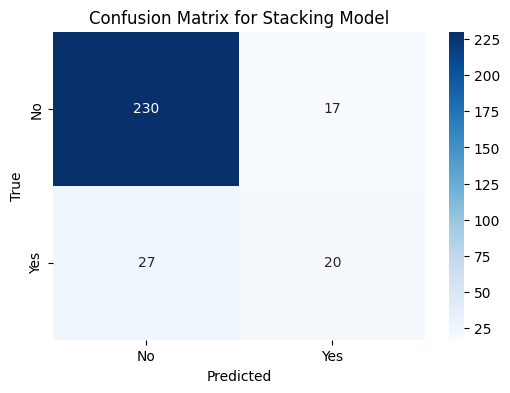

In [ ]:


# Helper: preprocess with SMOTE and dummy variables
def preprocess_with_smote(df, target='Attrition'):
    X = df.drop(columns=[target])
    y = df[target]

    X = pd.get_dummies(X, drop_first=True)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    return X_train_res, X_test, y_train_res, y_test

# Confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Preprocess each theme
X_eng_train, X_eng_test, y_eng_train, y_eng_test = preprocess_with_smote(df_engagement)
X_well_train, X_well_test, y_well_train, y_well_test = preprocess_with_smote(df_wellbeing)
X_pay_train, X_pay_test, y_pay_train, y_pay_test = preprocess_with_smote(df_pay)

# Train base models
clf_eng = DecisionTreeClassifier()
clf_eng.fit(X_eng_train, y_eng_train)

clf_well = SVC(probability=True)
clf_well.fit(X_well_train, y_well_train)

clf_pay = DecisionTreeClassifier()
clf_pay.fit(X_pay_train, y_pay_train)

# Combine features for stacking
X_stack_train = np.hstack((X_eng_train, X_well_train, X_pay_train))
X_stack_test = np.hstack((X_eng_test, X_well_test, X_pay_test))
y_stack_train = y_eng_train
y_stack_test = y_eng_test

# Define and train stacking classifier
stacked_model = StackingClassifier(
    estimators=[
        ('engagement_tree', clf_eng),
        ('wellbeing_svm', clf_well),
        ('pay_tree', clf_pay) ],


    final_estimator=LogisticRegression(),
    #final_estimator=LogisticRegression(),
    passthrough=False,
    cv=5
)
stacked_model.fit(X_stack_train, y_stack_train)

# Evaluate
y_pred_stack = stacked_model.predict(X_stack_test)
print("Stacking Model Performance")
print(classification_report(y_stack_test, y_pred_stack, target_names=["No", "Yes"]))
plot_confusion_matrix(y_stack_test, y_pred_stack, "Stacking Model")



### model is saved to stacked_model variable  ###


#============================================================================================================================================================

In [ ]:
engagement_culture_cols = [
    'Attrition', 'BusinessTravel', 'Department', 'EducationField',
    'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction',
    'PerformanceRating', 'RelationshipSatisfaction',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]

wellbeing_cols = [
    'Attrition','Age', 'DistanceFromHome', 'Gender', 'MaritalStatus', 'OverTime',
    'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
    'YearsAtCompany', 'YearsSinceLastPromotion', 'NumCompaniesWorked'
]

pay_benefits_cols = [
    'Attrition','DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
    'PercentSalaryHike', 'StockOptionLevel', 'Education', 'JobLevel'
]

# Create new DataFrames for each theme
df_engagement = df[engagement_culture_cols].copy()
df_wellbeing = df[wellbeing_cols].copy()
df_pay = df[pay_benefits_cols].copy()

In [ ]:
subset4 = df_engagement[['Attrition','JobSatisfaction','JobInvolvement','YearsInCurrentRole','YearsWithCurrManager','EnvironmentSatisfaction']]

In [ ]:
# Step 1: Copy to avoid modifying original
subset4_numeric = subset4.copy()

# Step 2: Convert 'Attrition' to binary (Yes/No → 1/0)
subset4_numeric['Attrition'] = subset4_numeric['Attrition'].map({'Yes': 1, 'No': 0})

# Step 3: Check for other object/categorical columns
# If any of the remaining are object types (e.g., strings), convert them using LabelEncoder or pd.factorize
for col in subset4_numeric.columns:
    if subset4_numeric[col].dtype == 'object':
        subset4_numeric[col] = pd.factorize(subset4_numeric[col])[0]  # fast and simple encoding

# Optional: Check final types
print(subset4_numeric.dtypes)


Attrition                  int64
JobSatisfaction            int64
JobInvolvement             int64
YearsInCurrentRole         int64
YearsWithCurrManager       int64
EnvironmentSatisfaction    int64
dtype: object


In [ ]:
subset4_numeric.isna().sum()


,0
Attrition,0
JobSatisfaction,0
JobInvolvement,0
YearsInCurrentRole,0
YearsWithCurrManager,0
EnvironmentSatisfaction,0


Attrition                   int64
JobSatisfaction            object
JobInvolvement             object
YearsInCurrentRole          int64
YearsWithCurrManager        int64
EnvironmentSatisfaction    object
dtype: object
Shape: (1470, 6)


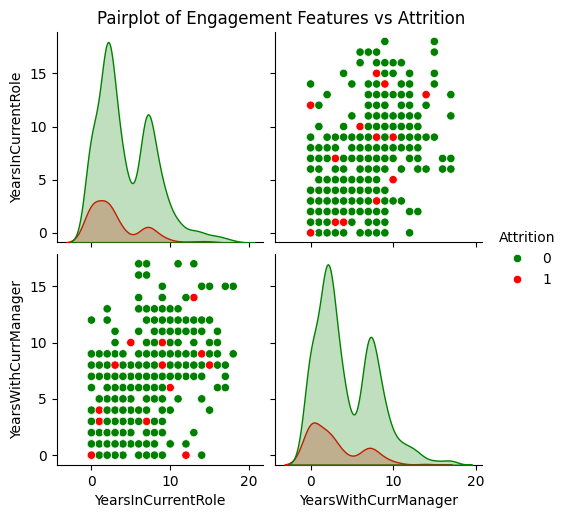

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create subset
subset4 = df_engagement[['Attrition','JobSatisfaction','JobInvolvement',
                         'YearsInCurrentRole','YearsWithCurrManager',
                         'EnvironmentSatisfaction']].copy()

# Step 2: Convert Attrition to numeric
subset4['Attrition'] = subset4['Attrition'].map({'Yes': 1, 'No': 0})

# Step 3: Drop missing values just in case
subset4 = subset4.dropna()

# Step 4: Confirm numeric
print(subset4.dtypes)

# Step 5: Confirm shape
print("Shape:", subset4.shape)

# Step 6: Generate pairplot
sns.pairplot(subset4, hue='Attrition', palette={1: 'red', 0: 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Engagement Features vs Attrition", y=1.02)
plt.show()


In [ ]:
satisfaction_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very High': 4
}

subset4['JobSatisfaction'] = subset4['JobSatisfaction'].map(satisfaction_map)
subset4['JobInvolvement'] = subset4['JobInvolvement'].map(satisfaction_map)
subset4['EnvironmentSatisfaction'] = subset4['EnvironmentSatisfaction'].map(satisfaction_map)


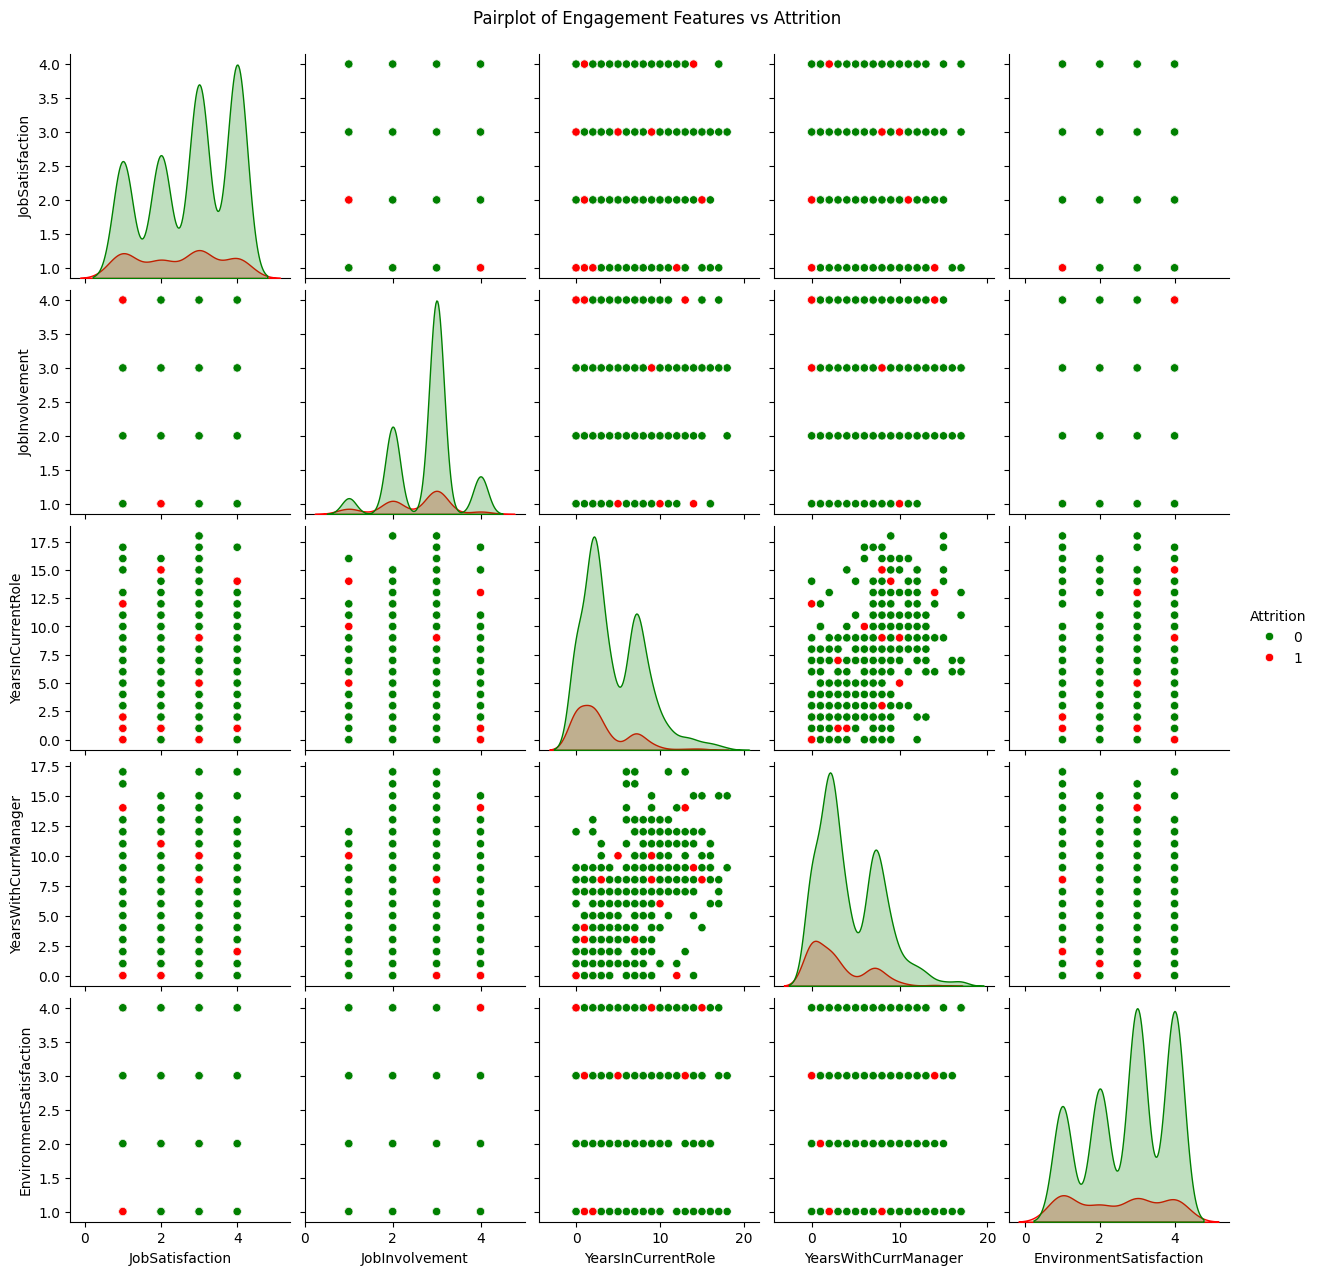

In [ ]:
sns.pairplot(subset4, hue='Attrition', palette={1: 'red', 0: 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Engagement Features vs Attrition", y=1.02)
plt.show()

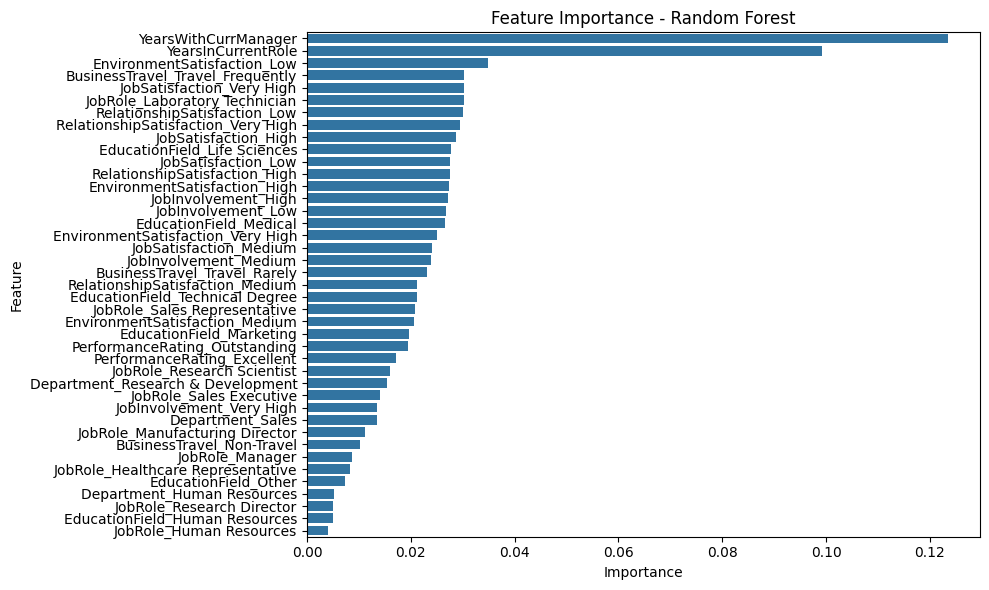

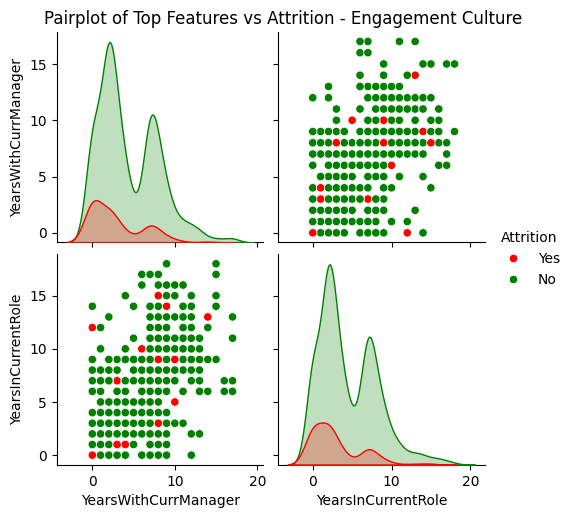

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Example with engagement_culture_cols
selected_cols = engagement_culture_cols

# Define X and y
X = df[selected_cols].drop('Attrition', axis=1)
y = df['Attrition']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Build pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit model
rf_pipeline.fit(X_train, y_train)

# Get feature names
onehot_feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_feature_names = list(onehot_feature_names) + numeric_cols

# Get feature importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# Filter top features to numeric ones only
numeric_top_features = [feat for feat in feat_imp.index if feat in numeric_cols]
top_numeric_features = numeric_top_features[:5]  # take top 5 numeric features

# Add Attrition to plot columns
plot_cols = top_numeric_features + ['Attrition']

# Create DataFrame for pairplot
plot_df = df[plot_cols].copy()
plot_df['Attrition'] = plot_df['Attrition'].astype(str)

# Plot
sns.pairplot(plot_df, hue='Attrition', palette={'Yes': 'red', 'No': 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Top Features vs Attrition - Engagement Culture", y=1.02)
plt.show()

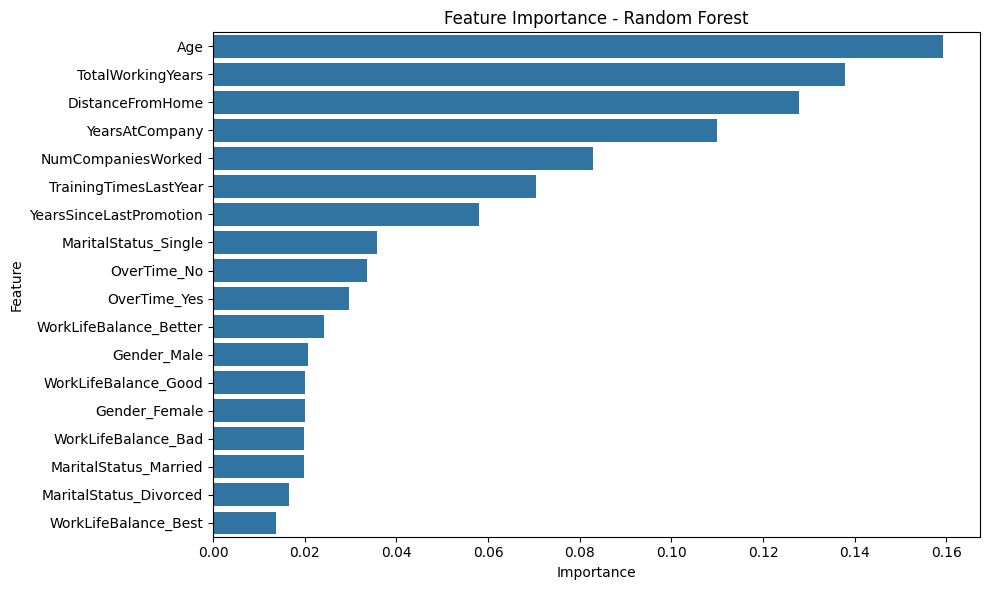

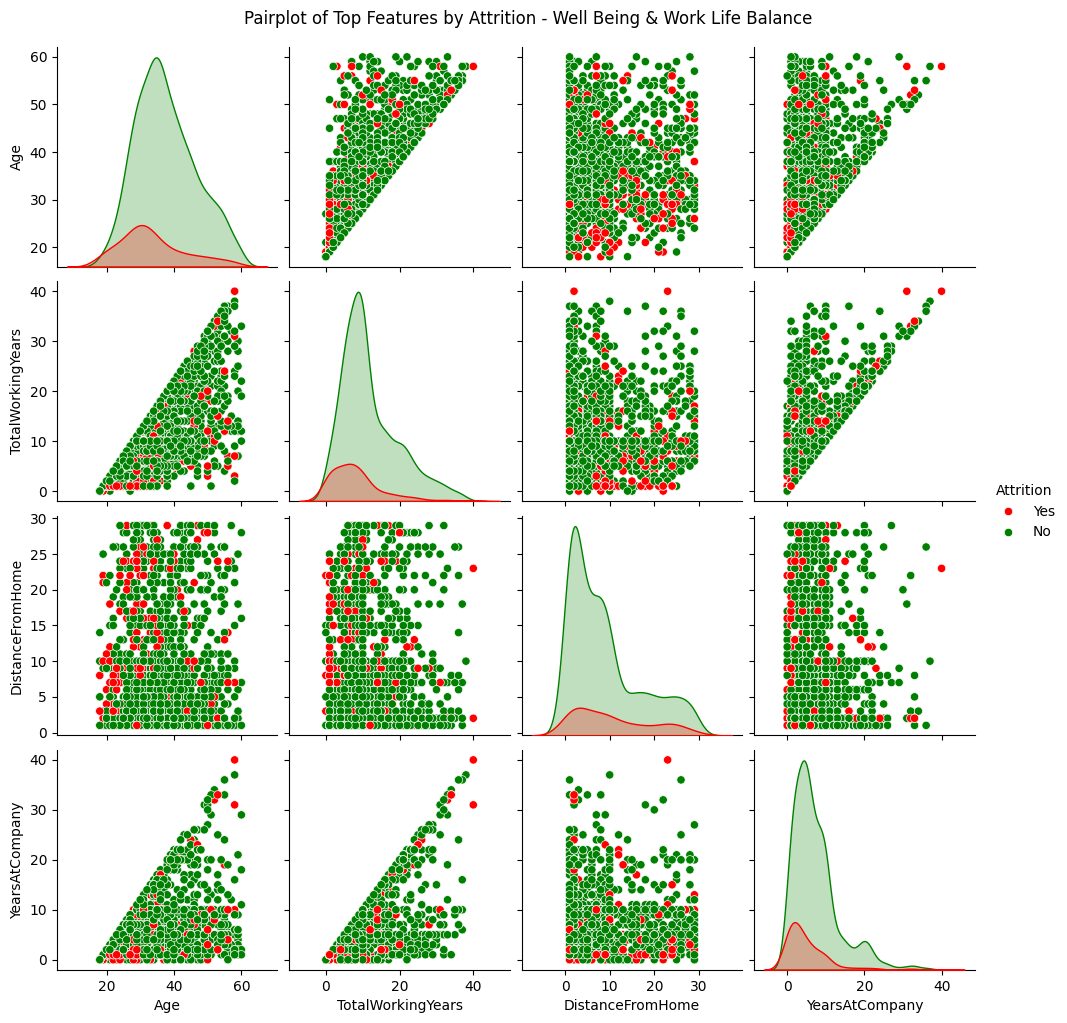

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Example with engagement_culture_cols
selected_cols = wellbeing_cols  # switch this to wellbeing_cols or pay_benefits_cols as needed

# Define X and y
X = df[selected_cols].drop('Attrition', axis=1)
y = df['Attrition']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Build pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit model
rf_pipeline.fit(X_train, y_train)

# Get feature names
onehot_feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_feature_names = list(onehot_feature_names) + numeric_cols

# Get feature importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Get top 4 features
top4_features = feat_imp.head(4).index.tolist()

# Create a DataFrame with just those features + Attrition
plot_df = df[top4_features + ['Attrition']].copy()

# Optional: ensure 'Attrition' is treated as a category
plot_df['Attrition'] = plot_df['Attrition'].astype(str)

# Plot pairplot
sns.pairplot(plot_df, hue='Attrition', palette= {'Yes': 'red', 'No': 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Top Features by Attrition - Well Being & Work Life Balance", y=1.02)
plt.show()



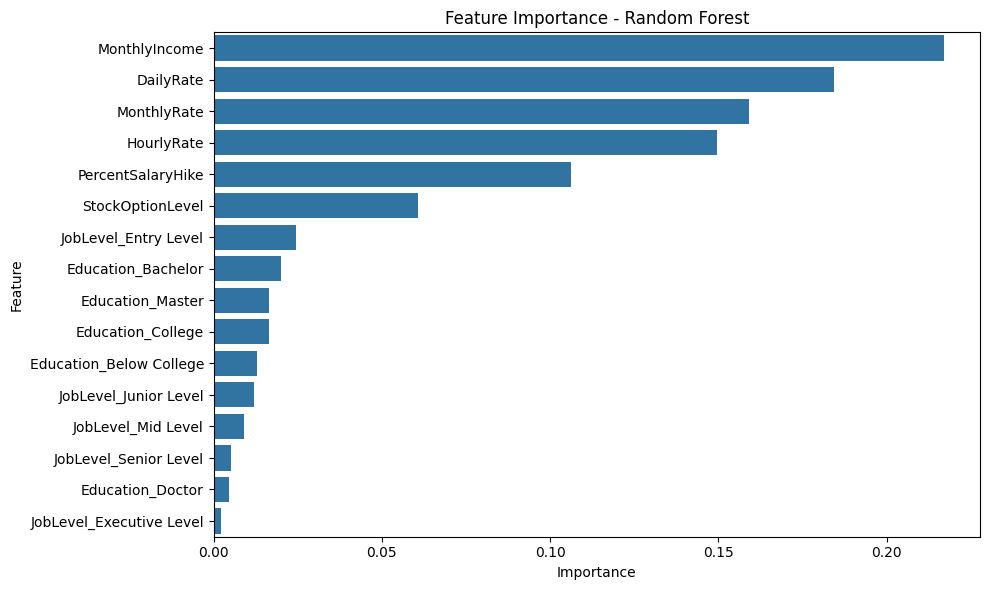

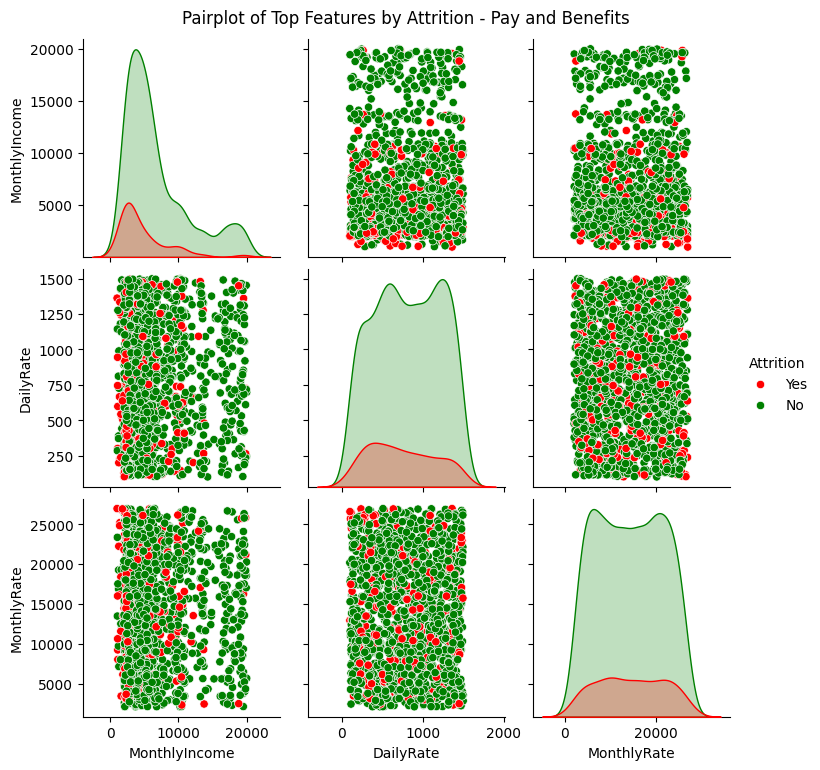

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Example with engagement_culture_cols
selected_cols = pay_benefits_cols  # switch this to wellbeing_cols or pay_benefits_cols as needed

# Define X and y
X = df[selected_cols].drop('Attrition', axis=1)
y = df['Attrition']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Build pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit model
rf_pipeline.fit(X_train, y_train)

# Get feature names
onehot_feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_feature_names = list(onehot_feature_names) + numeric_cols

# Get feature importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# Get top 5 features
top3_features = feat_imp.head(3).index.tolist()

# Create a DataFrame with just those features + Attrition
plot_df = df[top3_features + ['Attrition']].copy()

# Optional: ensure 'Attrition' is treated as a category
plot_df['Attrition'] = plot_df['Attrition'].astype(str)

# Plot pairplot
sns.pairplot(plot_df, hue='Attrition', palette= {'Yes': 'red', 'No': 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Top Features by Attrition - Pay and Benefits", y=1.02)
plt.show()





In [ ]:
df_pay.head()

,Attrition,DailyRate,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike,StockOptionLevel,Education,JobLevel
0,Yes,1102,94,5993,19479,11,0,College,Junior Level
1,No,279,61,5130,24907,23,1,Below College,Junior Level
2,Yes,1373,92,2090,2396,15,0,College,Entry Level
3,No,1392,56,2909,23159,11,0,Master,Entry Level
4,No,591,40,3468,16632,12,1,Below College,Entry Level


In [ ]:
df_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Attrition          1470 non-null   object
 1   DailyRate          1470 non-null   int64 
 2   HourlyRate         1470 non-null   int64 
 3   MonthlyIncome      1470 non-null   int64 
 4   MonthlyRate        1470 non-null   int64 
 5   PercentSalaryHike  1470 non-null   int64 
 6   StockOptionLevel   1470 non-null   int64 
 7   Education          1470 non-null   object
 8   JobLevel           1470 non-null   object
dtypes: int64(6), object(3)
memory usage: 103.5+ KB


In [ ]:
subset6 = df_pay[['Attrition','MonthlyIncome','PercentSalaryHike','JobLevel','StockOptionLevel']]

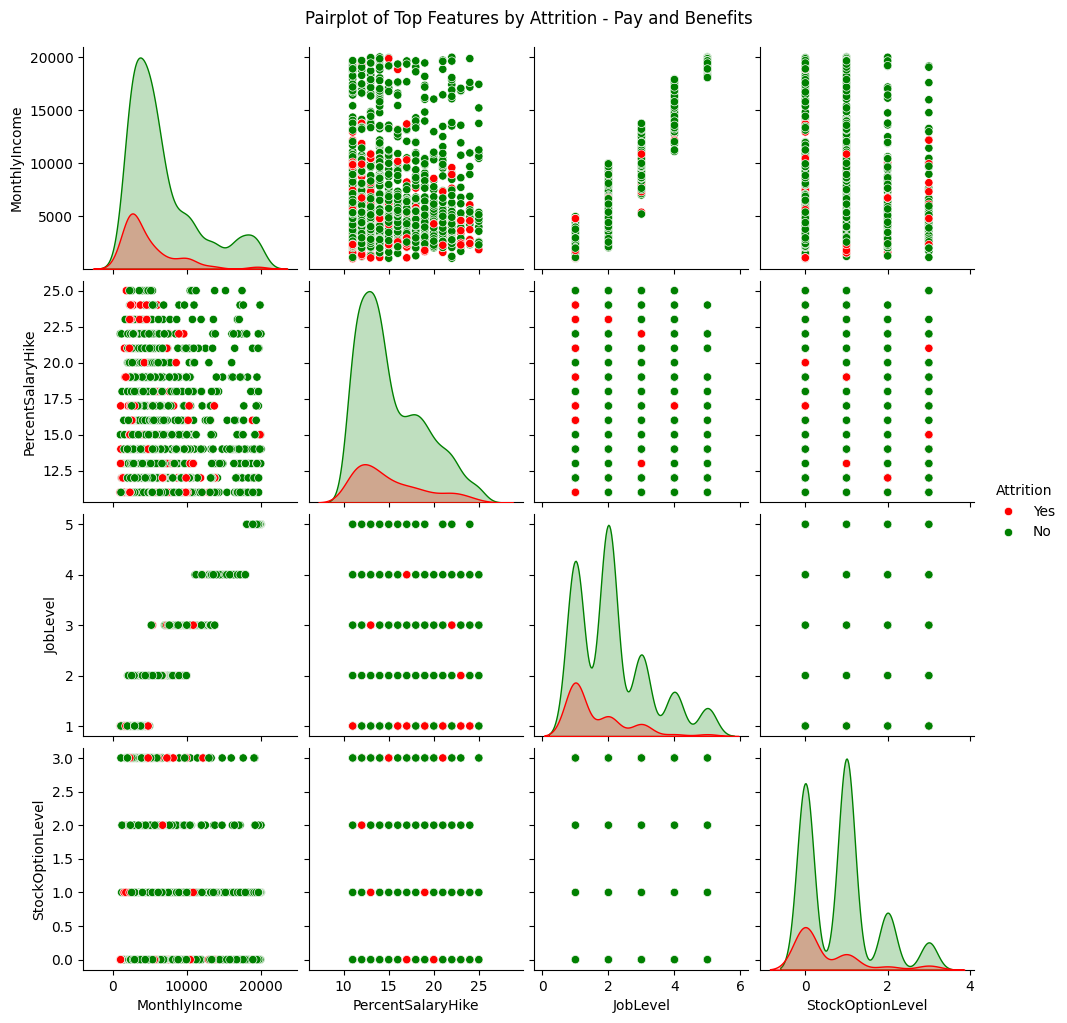

In [ ]:
sns.pairplot(subset6, hue='Attrition', palette= {'Yes': 'red', 'No': 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Top Features by Attrition - Pay and Benefits", y=1.02)
plt.show()

In [ ]:
education_map = {
    'Below College': 1,
    'College': 2,
    'Bachelor': 3,
    'Master': 4,
    'Doctor': 5
}
df_pay['Education'] = df_pay['Education'].map(education_map)

In [ ]:
df_pay['JobLevel'].value_counts()

,count
JobLevel,
Entry Level,543
Junior Level,534
Mid Level,218
Senior Level,106
Executive Level,69


In [ ]:
job_level_map = {
    'Entry Level': 1,
    'Junior Level': 2,
    'Mid Level': 3,
    'Senior Level': 4,
    'Executive Level': 5
}

df_pay['JobLevel'] = df_pay['JobLevel'].map(job_level_map)


In [ ]:
df_engagement.head()

,Attrition,BusinessTravel,Department,EducationField,EnvironmentSatisfaction,JobInvolvement,JobRole,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,YearsInCurrentRole,YearsWithCurrManager
0,Yes,Travel_Rarely,Sales,Life Sciences,Medium,High,Sales Executive,Very High,Excellent,Low,4,5
1,No,Travel_Frequently,Research & Development,Life Sciences,High,Medium,Research Scientist,Medium,Outstanding,Very High,7,7
2,Yes,Travel_Rarely,Research & Development,Other,Very High,Medium,Laboratory Technician,High,Excellent,Medium,0,0
3,No,Travel_Frequently,Research & Development,Life Sciences,Very High,High,Research Scientist,High,Excellent,High,7,0
4,No,Travel_Rarely,Research & Development,Medical,Low,High,Laboratory Technician,Medium,Excellent,Very High,2,2


In [ ]:
df_engagement['BusinessTravel'].value_counts()

,count
BusinessTravel,
Travel_Rarely,1043
Travel_Frequently,277
Non-Travel,150


In [ ]:
BusinessTravel_map = {
    'Travel_Rarely': 1,
    'Travel_Frequently': 2,
    'Non-Travel': 3
}

df_engagement['BusinessTravel'] = df_engagement['BusinessTravel'].map(jobinvolvement_level_map)

In [ ]:
df_engagement['EnvironmentSatisfaction'].value_counts()

,count
EnvironmentSatisfaction,
High,453
Very High,446
Medium,287
Low,284


In [ ]:
df_engagement['JobInvolvement'].value_counts()

,count
JobInvolvement,
High,868
Medium,375
Very High,144
Low,83


In [ ]:
jobinvolvement_level_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very High': 4
}

df_engagement['JobInvolvement'] = df_engagement['JobInvolvement'].map(jobinvolvement_level_map)

In [ ]:
environment_satisfaction_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very High': 4
}
df_engagement['EnvironmentSatisfaction'] = df_engagement['EnvironmentSatisfaction'].map(environment_satisfaction_map)

In [ ]:
job_satisfaction_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very High': 4
}
df_engagement['JobSatisfaction'] = df_engagement['JobSatisfaction'].map(job_satisfaction_map)

In [ ]:
relationship_satisfaction_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
}

df_engagement['RelationshipSatisfaction'] = df_engagement['RelationshipSatisfaction'].map(relationship_satisfaction_map)

In [ ]:
subset7 = df_engagement[['Attrition','RelationshipSatisfaction','EnvironmentSatisfaction','YearsInCurrentRole','YearsWithCurrManager']]

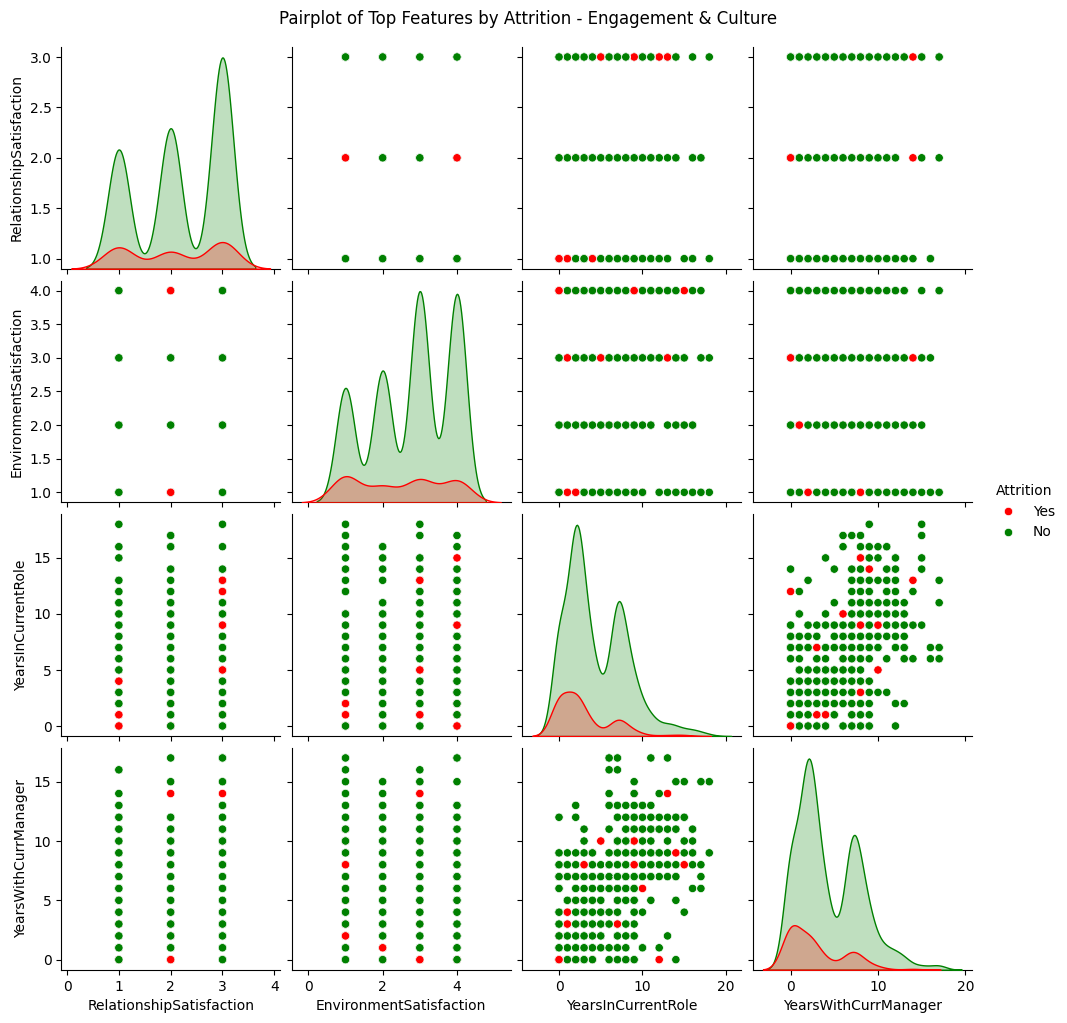

In [ ]:
subset8 = df_engagement[['Attrition','RelationshipSatisfaction','EnvironmentSatisfaction','YearsInCurrentRole','BusinessTravel']]
sns.pairplot(subset7, hue='Attrition', palette= {'Yes': 'red', 'No': 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Top Features by Attrition - Engagement & Culture", y=1.02)
plt.show()

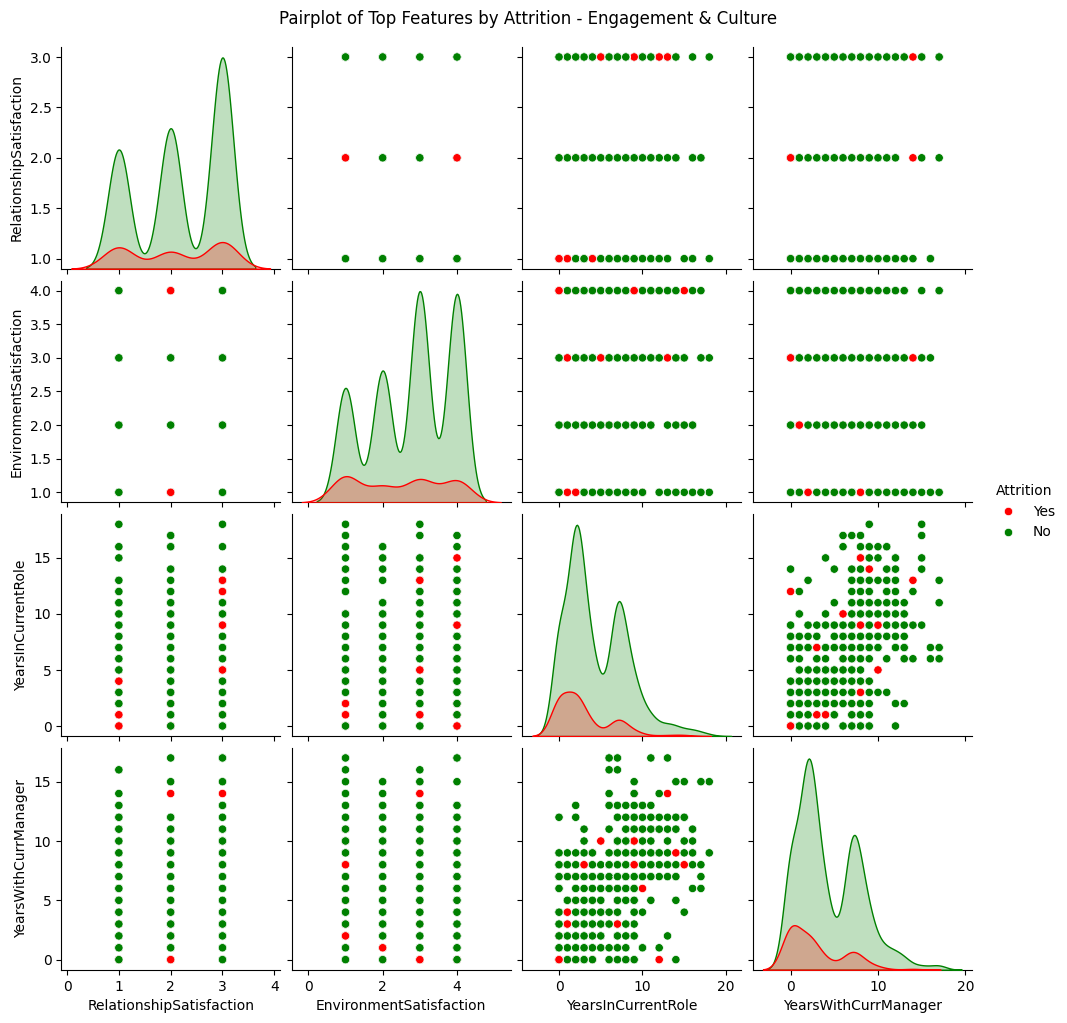

In [ ]:
sns.pairplot(subset7, hue='Attrition', palette= {'Yes': 'red', 'No': 'green'}, diag_kind='kde')
plt.suptitle("Pairplot of Top Features by Attrition - Engagement & Culture", y=1.02)
plt.show()